In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy

#from sim_handling import Simulation,loadSim #uses ds7
from sim_handling2 import Simulation,loadSim #ds8: faster, more space efficient
from diffusionstuff8 import f0d,f1d,f2d, getsigmastep_2d
from matplotlib.animation import PillowWriter

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
%matplotlib widget

#set figsize to be big (12,12) inches
#rcParams['figure.figsize'] = 10,10

filename: 200points_0.25smax_0.25c_r_1d_steps_time.png


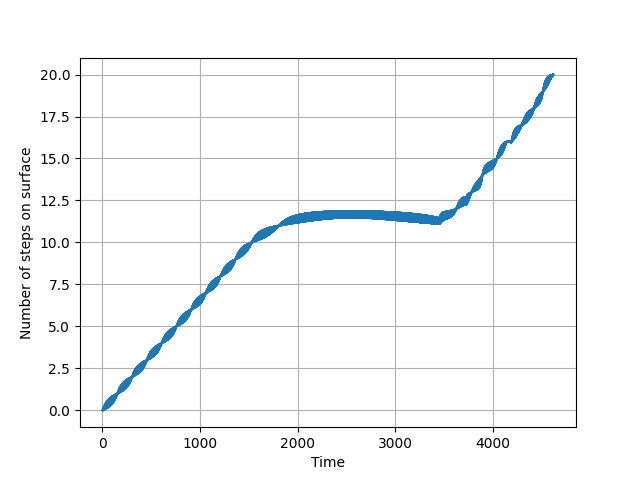

In [12]:
xsize = 200
ysize = 325


#for xsize in (range(100,500,50)):
#create 1d sim and graph number of steps over time
ss_1d = Simulation(f1d, (xsize,), method='RK45', rtol=1e-12)

ss_1d.noisy_init = False
ss_1d.float_params['DoverdeltaX2'] *= 0.5 
ss_1d.layermax = 10000
#ss_1d.sigmastepmax= -0.01 #ablation
ss_1d.sigmastepmax = 0.25 #growth
ss_1d.center_reduction= 0.25
#ss_1d.deltaT = *= 10 #increase time step to decrease number of steps saved


#print number of steps over time
Ntot = ss_1d.getNtot()

maxes = np.array([np.max(n) for n in Ntot[:]])
mins = np.array([np.min(n) for n in Ntot[:]])   

#Plot the number of steps over time
plt.figure()
ax = plt.axes()
ax.plot(Ntot[:,0],maxes-mins)
ax.set_ylabel('Number of steps on surface')
ax.set_xlabel('Time')
plt.grid()
#Save a plot of the number of steps over time to a png file
filename = str(xsize)+'points_'+ str(ss_1d.sigmastepmax) +'smax_'+ str(ss_1d.center_reduction) +'c_r_1d_steps_time.png'
print('filename:', filename)
plt.savefig(filename)

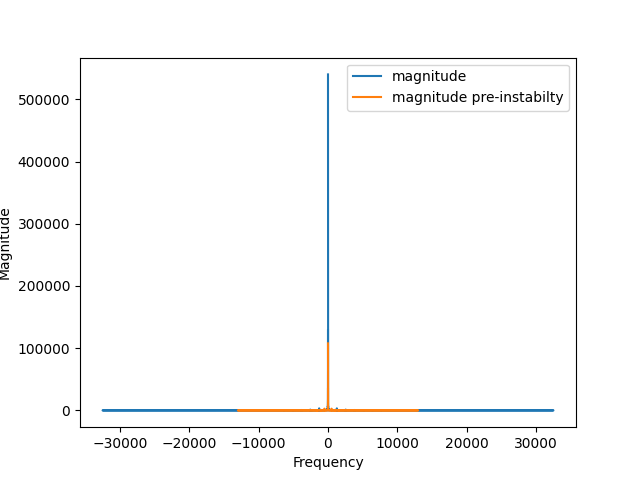

In [4]:
#fourier analysis
xs = Ntot[:,0]
ys = maxes-mins
ys_fft = np.fft.fft(ys)
freq = np.fft.fftfreq(xs.shape[-1])

#plot the fft
#plt.figure('Real and imaginary parts of FFT in freq domain')
plt.figure('fft of f(x)')
ax = plt.axes()
#ax.plot(freq, ys_fft.real, label='real')
#ax.plot(freq, ys_fft.imag, label='imaginary')

#ax.plot(freq, np.sqrt(ys_fft.real**2 + ys_fft.imag**2), label='magnitude')
ax.plot(list(map(lambda x: x*len(freq),freq)), np.sqrt(ys_fft.real**2 + ys_fft.imag**2), label='magnitude')

#ax.plot(freq, np.abs(ys_fft), label='magnitude')
#ax.stem(freq, np.abs(ys_fft), 'b', \
#         markerfmt=" ", basefmt="-b",label='magnitude')

ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude')

#plot the fft of just the part before numerical instability\
cutpoint = int(len(ys)*2/5)
ys_pre_num = ys[:cutpoint]
xs_pre_num = xs[:cutpoint]
ys_fft_pre_num = np.fft.fft(ys_pre_num)
freq_pre_num = np.fft.fftfreq(xs_pre_num.shape[-1])
ax.plot(list(map(lambda x: x*len(freq_pre_num),freq_pre_num)), np.sqrt(ys_fft_pre_num.real**2 + ys_fft_pre_num.imag**2), label='magnitude pre-instabilty')


#plot the fft with high frequencies filtered out
# ys_fft_filtered = ys_fft.copy()
# ys_fft_filtered[np.abs(freq) > 0.1] = 0
# ax.plot(freq, np.abs(ys_fft_filtered), label='magnitude filtered')

#ax.stem(freq, np.abs(ys_fft_filtered), 'r', \
#         markerfmt=" ", basefmt="-r",label='magnitude filtered')
ax.legend()


In [5]:
#calculate dominant frequencies
dominant_freqs = list(set(np.abs(freq[np.argsort(np.abs(ys_fft))[-6:]])*len(freq)))
print('Dominant frequencies:', dominant_freqs)

Dominant frequencies: [0.0, 1.0, 2.0, 3.0000000000000004]


C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'f(x)')

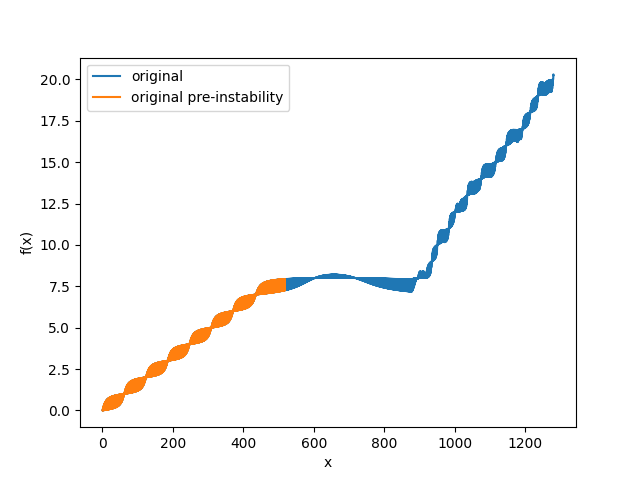

In [6]:
#plot the filtered signal and original signal reconstructed from fft
plt.figure('filtered signal')
ax = plt.axes()
ax.plot(xs, np.fft.ifft(ys_fft), label='original')  
ax.plot(xs_pre_num, np.fft.ifft(ys_fft_pre_num), label='original pre-instability')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('f(x)')

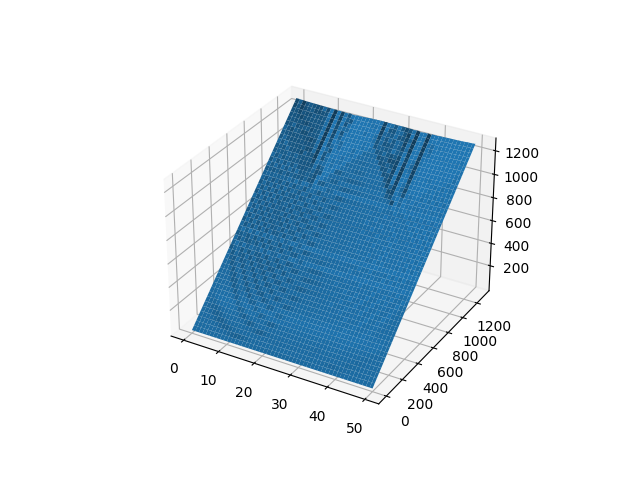

In [7]:
#plot 1d surface over time as 3d plot
Ntot = ss_1d.getNtot()
plt.figure('1d surface over time')
ax = plt.axes(projection='3d')
xs, ys = np.meshgrid(np.linspace(0,50,200), Ntot[:,0])
ax.plot_surface(xs,ys, Ntot[:,:])
plt.show()

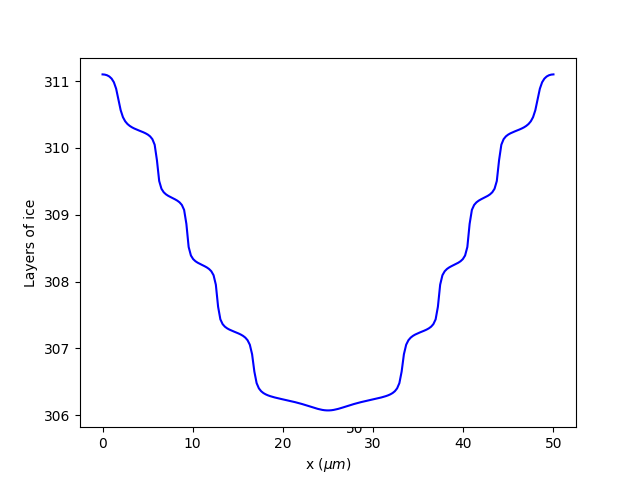

In [8]:
ax = plt.axes()
ax.plot(ss_1d.x, ss_1d.getNtot(38841*2//5), 'b', label='ice+QLL')
ax.set_xlabel(r'x ($\mu m$)')
ax.set_ylabel('Layers of ice')
plt.show()

In [9]:
plt.close()